Plotting functions to plot resolution matrices

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
import awkward as ak
plt.style.use(hep.style.CMS)

def read_file(f):
    df = pd.read_csv(f, sep="\t")
    return df

def get_combined_data(directory):
    dfs = [read_file(os.path.join(directory, f)) for f in os.listdir(directory)]
    SumWeight = np.sum([df.sumWeight[0] for df in dfs])
    DF = pd.concat(dfs, ignore_index=True)
    DF['SumWeight']= SumWeight
    return DF

In [2]:
def Get_resoltion_matrix(array1, array2, weights, minim, max, ints):
# Define the range and number of intervals
    # Generate sample data

    # Initialize matrix to store counts
    matrix = np.zeros((ints, ints), dtype=float)

    # Calculate the width of each interval
    interval_width = (max-minim) / ints

    # Iterate through each pair of points
    i=0
    for pt1, pt2 in zip(array1, array2):
        # Calculate the indices of the corresponding intervals for each point
        idx1 = min(int((pt1 - minim) / interval_width), ints - 1)
        idx2 = min(int((pt2 -minim) / interval_width), ints - 1)
        # Increment the count in the corresponding cell of the matrix
        matrix[idx1, idx2] += weights[i]
        i+=1
        
    # Normalize each column in the matrix
    column_sums = np.sum(matrix, axis=0)
    row_sums = np.sum(matrix, axis=1)
    column_normalized_matrix = matrix / column_sums
    row_normalized_matrix = matrix / row_sums
    return column_normalized_matrix, row_normalized_matrix

def Get_efficiency(arr, sel_arr, bins):
    counts, _= np.histogram(arr, bins=bins)
    selected_counts, _ = np.histogram(sel_arr, bins=bins)
    return selected_counts/counts   

def plot_resolution(matrix, min, max, ints, ax, fig):
    # Plot the normalized matrix using imshow
    
    interval_width = (max-min) / ints
    image = ax.imshow(matrix, origin='lower', aspect='auto', cmap='Greens', alpha=0.6)
    cbar = fig.colorbar(image, ax=ax)
    cbar.ax.tick_params(labelsize=16)
    hep.cms.label(ax=ax, fontsize=16, llabel='Simulation Internal', rlabel=r'138 fb$^{-1}$ (13 TeV)')
    # Add text annotations for matrix values in each tile
    for i in range(ints):
        for j in range(ints):
            ax.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='black')
            
    # Customize tick labels for x and y axes
    interval_labels = [f'{min + i * interval_width:.1f}-{min + (i + 1) * interval_width:.1f}' for i in range(ints)]
    ax.set_yticks(np.arange(ints)) 
    ax.set_yticklabels(interval_labels, size=16)
    ax.set_xticks(np.arange(ints)) 
    ax.set_xticklabels(interval_labels, rotation=30, size=16)
    ax.set_ylabel(r'Rec. AK8 $p_T$ (GeV)', loc='top', size=16)
    ax.set_title('Resolution Matrix, ttZ 3 lep', size=20, y=1.15)

In [5]:
def plot_resolution2(x, y, w, bins, title):
    # Define non-uniform bin edges
    x_bins = bins
    y_bins = bins

    # Create a 2D histogram with custom bins
    H, xedges, yedges = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=w)

    # Normalize the histogram to the column totals
    H_normalized = H / H.sum(axis=0, keepdims=True)

    # Plot using pcolormesh
    fig, ax = plt.subplots(figsize=(8, 6))
    X, Y = np.meshgrid(xedges, yedges)
    c = ax.pcolormesh(X, Y, H_normalized, cmap='Greens', shading='auto', alpha=0.6)
    # Add text annotations for matrix values in each tile
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            #if H[i, j] > 0:  # Only annotate non-zero bins
            ax.text(xedges[j] + (xedges[j+1] - xedges[j]) / 2,
                    yedges[i] + (yedges[i+1] - yedges[i]) / 2,
                    f'{H_normalized[i, j]:.2f}',  # Format the percentage
                    color='black', ha='center', va='center')
                
    hep.cms.label(ax=ax, fontsize=16, llabel='Simulation Internal', rlabel=r'138 fb$^{-1}$ (13 TeV)')
    #interval_labels = [f'{min + i * interval_width:.1f}-{min + (i + 1) * interval_width:.1f}' for i in range(ints)]
    ax.set_yticks(xedges) 
    #ax.set_yticklabels(interval_labels, size=16)
    ax.set_xticks(yedges) 
    #ax.set_xticklabels(interval_labels, rotation=30, size=16)
    ax.set_ylabel(r'Rec. AK8 $p_T$ (GeV)', size=20)
    ax.set_xlabel(r'Gen. top $p_T$ (GeV)', size=20)
    ax.set_title(title, size=23, y=1.1)

    # Add colorbar
    fig.colorbar(c, ax=ax)
    plt.show()


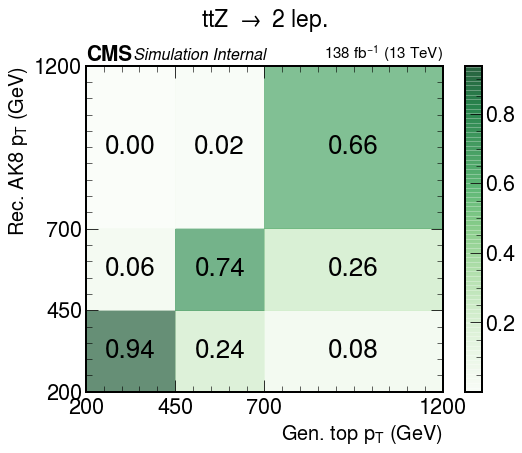

In [10]:
DF_ttZ = get_combined_data('final_results/resolution/output_TTZ/')
DFS_a = DF_ttZ.loc[DF_ttZ['Flag'] == 'a']
gen = np.array(DFS_a['Gent_pt'])
AK8 = np.array(DFS_a['AK8_pt'])
weights = np.array(DFS_a['genWeights'])
x = DF_ttZ['Gent_pt']
y = DF_ttZ['AK8_pt']
w = DF_ttZ['genWeights']
bins = [200, 450, 700, 1200]
title = r'ttZ $\rightarrow$ 2 lep.'

plot_resolution2(x, y, w, bins, title)